In [92]:
import pandas as pd

In [93]:
result_df = pd.read_csv("../out/stock_data.csv")

covid_data = pd.read_excel("../data/us_covid.xlsx")
covid_data = covid_data[["formatted_date","new_cases"]]


In [115]:
stock_prices = result_df.pivot(index='Date', columns='ticker', values='Close')
stock_return = stock_prices.pct_change()

#drop these companies due to insufficient data
stock_return = stock_return.drop(['OTIS', 'CARR', 'OGN'], axis=1)

C:\Users\maria\AppData\Local\Temp\ipykernel_14652\4281099123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data_df['formatted_date'] = pd.to_datetime(covid_data_df['formatted_date'], format='%Y%m%d')
C:\Users\maria\AppData\Local\Temp\ipykernel_14652\4281099123.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data_df['formatted_date'] = pd.to_datetime(covid_data_df['formatted_date'], format='%Y%m%d')


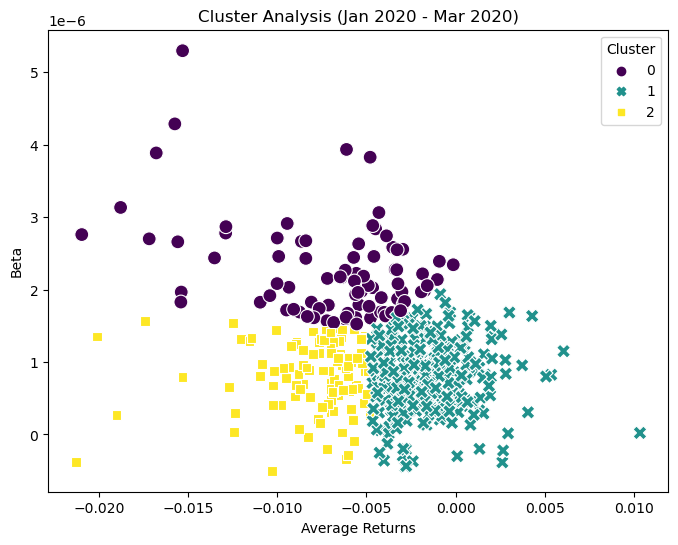

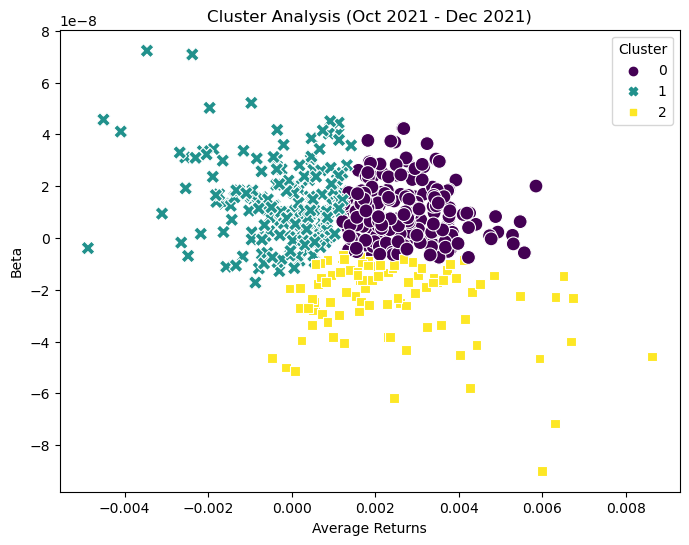

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming stock_return and covid_data are the given DataFrames

# Filter the stock_return DataFrame for each time frame
stock_return_pre = stock_return.loc['20200101':'20200331']
stock_return_post = stock_return.loc['20211001':'20211231']

# Filter the covid_data DataFrame for each time frame
covid_data_pre = covid_data.loc[(covid_data['formatted_date'] >= 20200101) & (covid_data['formatted_date'] <= 20200331)]
covid_data_post = covid_data.loc[(covid_data['formatted_date'] >= 20211001) & (covid_data['formatted_date'] <= 20211231)]

# Calculate beta for each stock in both time frames
def calculate_beta(stock_return_df, covid_data_df):
    # Align the dates between stock_return_df and covid_data_df
    stock_return_df = stock_return_df.reset_index()
    stock_return_df['Date'] = pd.to_datetime(stock_return_df['Date'], format='%Y%m%d')
    covid_data_df['formatted_date'] = pd.to_datetime(covid_data_df['formatted_date'], format='%Y%m%d')

    merged_df = stock_return_df.merge(covid_data_df, left_on='Date', right_on='formatted_date', how='inner')

    # Calculate the covariance between stock returns and new_cases
    covariances = {}
    for col in merged_df.columns[1:-2]:
        covariances[col] = merged_df[col].cov(merged_df['new_cases'])

    # Calculate the variance of new_cases
    variance = merged_df['new_cases'].var()

    # Calculate beta
    beta = {ticker: cov / variance for ticker, cov in covariances.items()}

    return beta

beta_pre = calculate_beta(stock_return_pre, covid_data_pre)
beta_post = calculate_beta(stock_return_post, covid_data_post)



def cluster_analysis(stock_return_df, beta):
    # Calculate the average stock returns
    avg_returns = stock_return_df.mean()

    # Convert the beta dictionary to a DataFrame
    beta_df = pd.DataFrame(list(beta.items()), columns=['Ticker', 'Beta']).set_index('Ticker')

    # Combine average stock returns and beta values into a single DataFrame
    data = pd.concat([avg_returns, beta_df], axis=1)
    data.columns = ['Avg_Returns', 'Beta']

    # Fill NaN values with 0
    data = data.fillna(0)

    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Cluster the data
    kmeans = KMeans(n_clusters=3, random_state=0).fit(scaled_data)

    # Add the cluster labels to the original data
    data['Cluster'] = kmeans.labels_

    return data

clustered_data_pre = cluster_analysis(stock_return_pre, beta_pre)
clustered_data_post = cluster_analysis(stock_return_post, beta_post)


# Plot the clusters
def plot_clusters(clustered_data, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=clustered_data, x='Avg_Returns', y='Beta', hue='Cluster', palette='viridis', style='Cluster', s=100)
    plt.title(title)
    plt.xlabel('Average Returns')
    plt.ylabel('Beta')
    plt.show()

plot_clusters(clustered_data_pre, 'Cluster Analysis (Jan 2020 - Mar 2020)')
plot_clusters(clustered_data_post, 'Cluster Analysis (Oct 2021 - Dec 2021)')

stock_industry = pd.read_csv("../data/stock_detail.csv")
stock_industry = stock_industry.iloc[:,:3]

pre_cov_cluster_df = pd.merge(clustered_data_pre,stock_industry,how="left",left_index= True, right_on= "Symbol")
psot_cov_cluster_df = pd.merge(clustered_data_post,stock_industry,how="left",left_index= True, right_on= "Symbol")




In [126]:
def cluster_analysis_with_centroids_and_scatter(clustered_data):
    # Calculate the centroids of each cluster
    centroids = clustered_data.groupby('Cluster').mean()[['Avg_Returns', 'Beta']]

    # Calculate the scatter distribution (sum of squared distances from points to their cluster's centroid) for each cluster
    scatter_distribution = {}
    for cluster_label in centroids.index:
        cluster_points = clustered_data[clustered_data['Cluster'] == cluster_label][['Avg_Returns', 'Beta']]
        centroid = centroids.loc[cluster_label]
        squared_distances = ((cluster_points - centroid) ** 2).sum(axis=1)
        scatter_distribution[cluster_label] = squared_distances.sum()

    return centroids, scatter_distribution

pre_centroids, pre_scatter_distribution = cluster_analysis_with_centroids_and_scatter(clustered_data_pre)
post_centroids, post_scatter_distribution = cluster_analysis_with_centroids_and_scatter(clustered_data_post)

print("Pre-COVID Centroids:\n", pre_centroids)
print("Pre-COVID Scatter Distribution:\n", pre_scatter_distribution)

print("Post-COVID Centroids:\n", post_centroids)
print("Post-COVID Scatter Distribution:\n", post_scatter_distribution)



Pre-COVID Centroids:
          Avg_Returns          Beta
Cluster                           
0          -0.007610  7.972136e-07
1          -0.001313  6.390166e-07
2          -0.012859  2.686672e-06
3          -0.003364  1.704681e-06
Pre-COVID Scatter Distribution:
 {0: 0.0008218511175911126, 1: 0.0010659866831348105, 2: 0.0004708083826251387, 3: 0.0005972094861254924}
Post-COVID Centroids:
          Avg_Returns          Beta
Cluster                           
0           0.000818 -1.021262e-08
1           0.004164 -2.181448e-08
2           0.002390  1.250830e-08
3          -0.000585  2.013074e-08
Post-COVID Scatter Distribution:
 {0: 0.00010183654676204276, 1: 0.00010056803845198826, 2: 0.0001609448714694218, 3: 0.00017206751472508992}


In [118]:
# Companies in each cluster before March 2020
for i in range(4):
    print(f'Cluster {i}:')
    print(clustered_data_pre[clustered_data_pre['Cluster']==i].index.values)

# Companies in each cluster after March 2020
for i in range(4):
    print(f'Cluster {i}:')
    print(clustered_data_post[clustered_data_post['Cluster']==i].index.values)

Cluster 0:
['AAL' 'AAP' 'ACGL' 'AIG' 'ALGN' 'ALK' 'AMP' 'APA' 'APH' 'APTV' 'AXP'
 'AZO' 'BAC' 'BBY' 'BEN' 'BKR' 'BWA' 'BXP' 'C' 'CBRE' 'CDW' 'CFG' 'CMA'
 'COF' 'CTAS' 'DAL' 'DD' 'DHI' 'DIS' 'DISH' 'DOW' 'EMN' 'EOG' 'EXPE' 'F'
 'FITB' 'FLT' 'FOX' 'FOXA' 'FRC' 'FRT' 'FSLR' 'GLW' 'GM' 'GS' 'GWW' 'HBAN'
 'HCA' 'HES' 'HIG' 'HII' 'HLT' 'HPE' 'HST' 'HWM' 'IP' 'IT' 'IVZ' 'JCI'
 'JPM' 'KEY' 'KIM' 'KMX' 'L' 'LUV' 'LVS' 'MAR' 'MAS' 'MCHP' 'MHK' 'MRO'
 'MS' 'MTB' 'NRG' 'NWL' 'NWS' 'NWSA' 'NXPI' 'OMC' 'ON' 'ORLY' 'PFG' 'PHM'
 'PNC' 'PPG' 'QRVO' 'RE' 'REG' 'RF' 'RHI' 'RL' 'RTX' 'SCHW' 'SEE' 'SLB'
 'SNA' 'SPG' 'SYF' 'SYY' 'TDG' 'TEL' 'TFC' 'TPR' 'TSN' 'TXT' 'USB' 'VFC'
 'VTR' 'WAB' 'WBD' 'WELL' 'WFC' 'WHR' 'WY' 'WYNN' 'XOM' 'YUM' 'ZION']
Cluster 1:
['A' 'AAPL' 'ABBV' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADSK' 'AEE' 'AEP' 'AIZ'
 'AJG' 'AKAM' 'ALB' 'ALLE' 'AMD' 'AMGN' 'AMT' 'AMZN' 'ANSS' 'AON' 'AOS'
 'APD' 'ARE' 'ATO' 'ATVI' 'AVB' 'AVY' 'AWK' 'BALL' 'BAX' 'BBWI' 'BDX'
 'BF-B' 'BIIB' 'BIO' 'BR' 'BRK-B' 'BRO'

In [119]:
stock_industry = pd.read_csv("../data/stock_detail.csv")
stock_industry = stock_industry.iloc[:,:3]
pre_cov_cluster_df = pd.merge(clustered_data_pre,stock_industry,how="left",left_index= True, right_on= "Symbol")

In [120]:
pre_cov_cluster_df.columns[-1]

'Sector'

In [121]:
(pre_cov_cluster_df.query("Cluster==1")["Sector"].value_counts()).sum()

224

In [122]:
for iters in range(0,4):
    print(f"now cluster {iters}")
    temp_cluster_gpX_df = pre_cov_cluster_df.query("Cluster==@iters")["Sector"].value_counts()
    print(temp_cluster_gpX_df/(temp_cluster_gpX_df.sum()))
    print(temp_cluster_gpX_df.sum())
    
        

now cluster 0
Financials                0.271186
Consumer Discretionary    0.194915
Industrials               0.135593
Information Technology    0.093220
Real Estate               0.084746
Communication Services    0.067797
Energy                    0.059322
Materials                 0.050847
Health Care               0.016949
Consumer Staples          0.016949
Utilities                 0.008475
Name: Sector, dtype: float64
118
now cluster 1
Health Care               0.160714
Information Technology    0.156250
Financials                0.120536
Consumer Staples          0.116071
Industrials               0.111607
Utilities                 0.089286
Real Estate               0.075893
Consumer Discretionary    0.062500
Materials                 0.049107
Communication Services    0.049107
Energy                    0.008929
Name: Sector, dtype: float64
224
now cluster 2
Energy                    0.407407
Consumer Discretionary    0.259259
Industrials               0.111111
Financials       

In [124]:
for iters in range(0,4):
    print(f"now cluster {iters}")
    temp_cluster_gpX_df = psot_cov_cluster_df.query("Cluster==@iters")["Sector"].value_counts()
    print(temp_cluster_gpX_df/(temp_cluster_gpX_df.sum()))
    print(temp_cluster_gpX_df.sum())

now cluster 0
Financials                0.344
Industrials               0.152
Energy                    0.128
Information Technology    0.104
Consumer Discretionary    0.104
Consumer Staples          0.064
Materials                 0.056
Health Care               0.032
Communication Services    0.016
Name: Sector, dtype: float64
125
now cluster 1
Information Technology    0.418182
Industrials               0.145455
Energy                    0.109091
Materials                 0.090909
Consumer Discretionary    0.054545
Financials                0.054545
Health Care               0.036364
Consumer Staples          0.036364
Real Estate               0.036364
Communication Services    0.018182
Name: Sector, dtype: float64
55
now cluster 2
Health Care               0.159204
Utilities                 0.139303
Industrials               0.134328
Consumer Discretionary    0.124378
Real Estate               0.124378
Consumer Staples          0.099502
Information Technology    0.094527
Materials 

c:\Users\maria\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


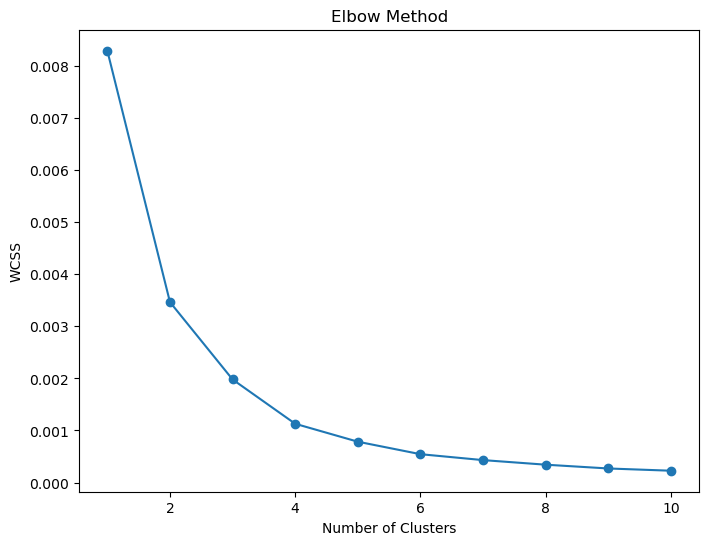

In [131]:
from sklearn.cluster import KMeans

# Calculate WCSS for different numbers of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(cluster_analysis(stock_return_pre, beta_pre).drop('Cluster', axis=1))
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# the interpretation of this is that we should choose 4 cluster as after that number the wcss does not decrease anymore significantly


In [125]:
temp_cluster_gpX_df

Health Care               25
Communication Services    18
Financials                17
Industrials               17
Consumer Discretionary    12
Information Technology    11
Consumer Staples           6
Materials                  4
Real Estate                3
Energy                     1
Utilities                  1
Name: Sector, dtype: int64